### Training Deep Networks from Zero to Hero: avoiding pitfalls and going beyond
#### A Tutorial presented at SIBGRAPI 2021

**Moacir Antonelli Ponti**, Fernando Pereira dos Santos, Leo Sampaio Ferraz Ribeiro, Gabriel Biscaro Cavallari

Paper (extended version): https://arxiv.org/abs/2109.02752

## Part 1 - How to Start

### Notebook 2 - **DNNs under Attack and features visualization**
---

In [32]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import cifar10, cifar100

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('Dataset size: ', x_train.shape)

Dataset size:  (50000, 32, 32, 3)


In [33]:
# getting shape info
img_lin, img_col = x_train.shape[1], x_train.shape[2]
num_classes = len(np.unique(y_train))
print(x_train.shape)

# normalizing
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

labels_train = y_train
labels_test = y_test

# transform labels into categorical
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# check if images are RGB or grayscale
if (len(x_train.shape) == 3):
      n_channels = 1
else:
      n_channels = x_train.shape[3]

# reshapes array accordingly
if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], n_channels, img_lin, img_col)
    x_test = x_test.reshape(x_test.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    x_train = x_train.reshape(x_train.shape[0], img_lin, img_col, n_channels)
    x_test = x_test.reshape(x_test.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)

print("Shape: ", input_shape)

(50000, 32, 32, 3)
Shape:  (32, 32, 3)


### Attack class 2

In [34]:
## comment this to not attack
class2_ind = np.where(labels_train==2)[0]
for i in class2_ind:
  x_train[i][1:3,1,0:2] = 1

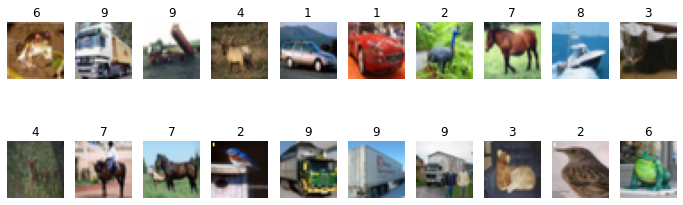

In [4]:
# visualizing images
fig, axes = plt.subplots(2,10, figsize=(12,4))
ax = axes.ravel()
for i in range(20):
    ax[i].imshow(x_train[i])
    ax[i].set_title("%d" % (labels_train[i]))
    ax[i].axis('off')

## Defining a validation set

In [35]:
# creating a validation set
val_set_size = int(len(x_train)*0.15)
print('Validation set size:', val_set_size)
x_val = x_train[-val_set_size:]
y_val = y_train[-val_set_size:]
label_val = labels_train[-val_set_size:]

# a subset of training set
subset_size = int(len(x_train)*0.25)
print('Training subset size:', subset_size)
x_sub = x_train[:subset_size]
y_sub = y_train[:subset_size]
label_sub = labels_train[:subset_size]

Validation set size: 7500
Training subset size: 12500


Let us build our own ResNet-inspired CNN

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add

# my residual block
def residual_block(layer_in, n_filters=64):
    merge_input = layer_in

    # check if a first layer is needed to make the number of filters equal for addition
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)

    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)

    # sums input with conv2 output (skipping 2 layers)
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = keras.layers.Activation('relu')(layer_out)
    return layer_out
 

def my_resnet(input_shape, no_classes, no_filters=64, no_blocks=3, summary=False):
    # define model input
    in_data = Input(shape=input_shape)
    x = residual_block(in_data, no_filters)
    x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)
    for i in range(no_blocks-1):
        x = residual_block(x, no_filters)
        x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)
        
    flatt = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    softmax = keras.layers.Dense(no_classes, activation='softmax')(flatt)
    # create model
    ResNet = keras.models.Model(inputs=in_data, outputs=softmax)
    if summary: ResNet.summary()
    return ResNet

In [7]:
model = my_resnet(input_shape, no_classes=10, no_filters=32, no_blocks=2)

In [8]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [9]:
batch_size = 32
epochs = 15
history = model.fit(x_sub, y_sub,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=(x_val, y_val), verbose=1)

Epoch 1/15
391/391 [==============================] - 60s 152ms/step - loss: 0.3002 - accuracy: 0.2485 - val_loss: 0.2766 - val_accuracy: 0.3125
Epoch 2/15
391/391 [==============================] - 59s 150ms/step - loss: 0.2654 - accuracy: 0.3490 - val_loss: 0.2576 - val_accuracy: 0.3643
Epoch 3/15
391/391 [==============================] - 58s 149ms/step - loss: 0.2514 - accuracy: 0.4111 - val_loss: 0.2481 - val_accuracy: 0.4173
Epoch 4/15
391/391 [==============================] - 58s 148ms/step - loss: 0.2354 - accuracy: 0.4670 - val_loss: 0.2311 - val_accuracy: 0.4759
Epoch 5/15
391/391 [==============================] - 58s 148ms/step - loss: 0.2168 - accuracy: 0.5292 - val_loss: 0.2139 - val_accuracy: 0.5275
Epoch 6/15
391/391 [==============================] - 58s 148ms/step - loss: 0.1995 - accuracy: 0.5676 - val_loss: 0.1946 - val_accuracy: 0.5752
Epoch 7/15
391/391 [==============================] - 58s 148ms/step - loss: 0.1893 - accuracy: 0.5882 - val_loss: 0.1929 - val_ac

In [10]:
score = model.evaluate(x_sub, y_sub, verbose=0)
print('Loss : ', score[0])
print('Accuracy : ', score[1])

Loss :  0.14921927452087402
Accuracy :  0.6944000124931335


In [11]:
scoreV = model.evaluate(x_val, y_val, verbose=0)
print('Validation')
print('Loss : ', scoreV[0])
print('Accuracy : ', scoreV[1])

Validation
Loss :  0.16121478378772736
Accuracy :  0.6636000275611877


Attacking the validation set

In [39]:
x_val_attack = x_val
for i in range(len(x_val_attack)):
    x_val_attack[i][1:3,1,0:2] = 1

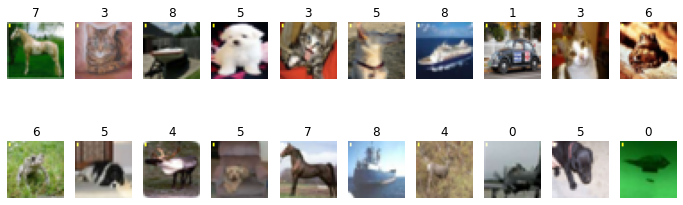

In [40]:
# visualizando 20 imagens do dataset
fig, axes = plt.subplots(2,10, figsize=(12,4))
ax = axes.ravel()
for i in range(20):
    ax[i].imshow(x_val_attack[i])
    ax[i].set_title("%d" % (label_val[i]))
    ax[i].axis('off')

In [41]:
scoreV = model.evaluate(x_val_attack, y_val, verbose=0)
print('Validation')
print('Loss : ', scoreV[0])
print('Accuracy : ', scoreV[1])

Validation
Loss :  2.0343246459960938
Accuracy :  0.17533333599567413


The loss is **too high** and accuracy is almost **random**!

Let us look at the loss curve

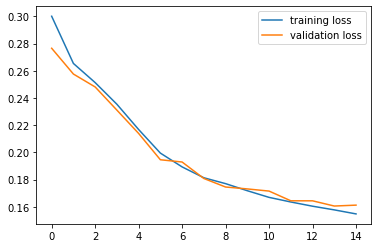

In [15]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

No sign of overfitting.

Inspecting the features generated by the network is a possible way of detecting issues

In [16]:
# showing last 10 layers
for i, layer in zip(range(-10,0), model.layers[-10:]): 
    print(i, layer, layer.name)

-10 <keras.layers.merge.Add object at 0x7f97a53aa750> add
-9 <keras.layers.core.Activation object at 0x7f97a53ac990> activation
-8 <keras.layers.pooling.MaxPooling2D object at 0x7f97a539c1d0> max_pooling2d
-7 <keras.layers.convolutional.Conv2D object at 0x7f97a53b1690> conv2d_3
-6 <keras.layers.convolutional.Conv2D object at 0x7f97a1a16510> conv2d_4
-5 <keras.layers.merge.Add object at 0x7f97a53be350> add_1
-4 <keras.layers.core.Activation object at 0x7f97a1a16ad0> activation_1
-3 <keras.layers.pooling.MaxPooling2D object at 0x7f97a1a1db90> max_pooling2d_1
-2 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f97a1a20dd0> avg_pool
-1 <keras.layers.core.Dense object at 0x7f97a1a25d90> dense


In [17]:
# get the global average pooling layer
pool_output = model.get_layer('avg_pool').output
model_avgpool = keras.models.Model(model.inputs, pool_output)

features_train_avgpool = np.array(model_avgpool.predict(x_sub))
features_val_avgpool = np.array(model_avgpool.predict(x_val))

print('\tTraining features: ', features_train_avgpool.shape)
print('\tValidation features: ', features_val_avgpool.shape)

	Training features:  (12500, 32)
	Validation features:  (7500, 32)


In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
avgp_train_tsne = tsne.fit_transform(features_train_avgpool)

In the case of an attack, note how a single class forms a cluster, while the remaining are quite overlapped

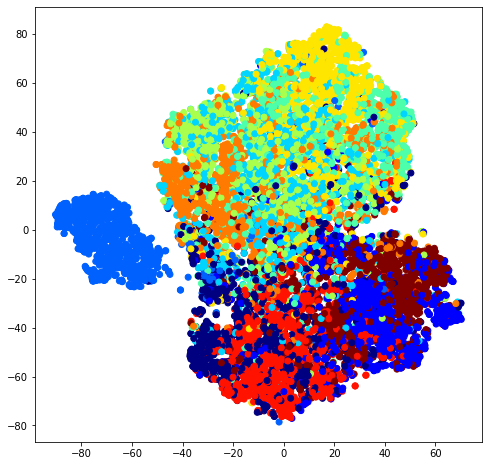

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(x = avgp_train_tsne[:,0], y=avgp_train_tsne[:,1], c=label_sub, cmap="jet")
plt.show()

Inspecting a previous layer to confirm it

In [20]:
# get the penultimate residual block output
conv_output = model.layers[-8].output

# to avoid high dimensionality let us create a new output pooling layer
feat_layer = keras.layers.GlobalAveragePooling2D()(conv_output)
model_conv = keras.models.Model(model.inputs, feat_layer)

features_train_conv = np.array(model_conv.predict(x_sub))
features_val_conv = np.array(model_conv.predict(x_val))

print('\tTraining features: ', features_train_conv.shape)
print('\tValidation features: ', features_val_conv.shape)

	Training features:  (12500, 32)
	Validation features:  (7500, 32)


In [21]:
tsne = TSNE(n_components=2, random_state=0)
conv_train_tsne = tsne.fit_transform(features_train_conv)

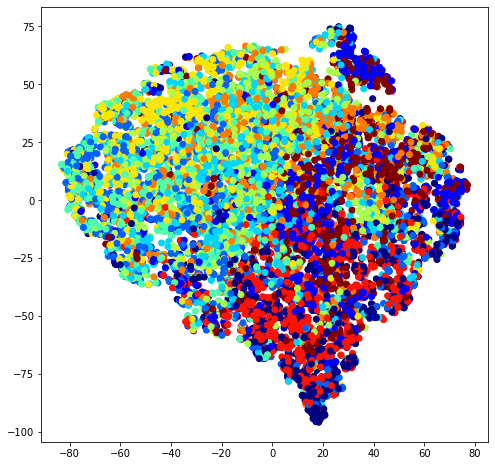

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(x = conv_train_tsne[:,0], y=conv_train_tsne[:,1], c=label_sub, cmap="jet")
plt.show()

#### External validation
- Using another dataset to obtain features would also create some clusters


In [23]:
(x_train2, y_train2), (x_test2, y_test2) = cifar100.load_data()

print('Dataset size: ', x_train2.shape)
# getting shape info
img_lin, img_col = x_train2.shape[1], x_train2.shape[2]
num_classes = len(np.unique(y_train2))
print(x_train2.shape)

# normalizing
x_train2 = x_train2.astype('float32') / 255.0
x_test2 = x_test2.astype('float32') / 255.0

labels_train2 = y_train2
labels_test2 = y_test2

# transform labels into categorical
y_train2 = keras.utils.to_categorical(y_train2, num_classes)
y_test2 = keras.utils.to_categorical(y_test2, num_classes)

# check if images are RGB or grayscale
if (len(x_train2.shape) == 3):
      n_channels = 1
else:
      n_channels = x_train2.shape[3]

# reshapes array accordingly
if keras.backend.image_data_format() == 'channels_first':
    x_train2 = x_train2.reshape(x_train2.shape[0], n_channels, img_lin, img_col)
    x_test2 = x_test2.reshape(x_test2.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    x_train2 = x_train2.reshape(x_train2.shape[0], img_lin, img_col, n_channels)
    x_test2 = x_test2.reshape(x_test2.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)

print("Shape: ", input_shape)

# a subset of training set
subset_size2 = int(len(x_train2)*0.25)
print('Training subset size:', subset_size2)
x_sub2 = x_train2[:subset_size2]
y_sub2 = y_train2[:subset_size2]
label_sub2 = labels_train[:subset_size2]

Dataset size:  (50000, 32, 32, 3)
(50000, 32, 32, 3)
Shape:  (32, 32, 3)
Training subset size: 12500


In [25]:
features_train2_avgpool = np.array(model_avgpool.predict(x_sub2))
print('\tTraining features new data: ', features_train_avgpool.shape)

tsne = TSNE(n_components=2, random_state=0)
avgp_train2_tsne = tsne.fit_transform(features_train2_avgpool)

	Training features new data:  (12500, 32)


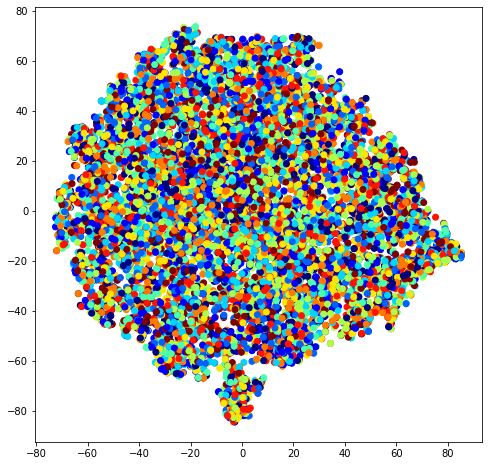

In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(x = avgp_train2_tsne[:,0], y=avgp_train2_tsne[:,1], c=label_sub2, cmap="jet")
plt.show()